In [1]:
import gc   # For manual garbage collection.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils import traceplots
from inference_toolbox import Parameter, Model, Likelihood, Sampler
from GPM_analysis import GPM_analysis

experiment = 'Exp1'

# Import and select data.
all_data = pd.read_csv('total_data.csv',
    usecols = ['gps.lat', 'gps.lon', 'altitudeRelative', 'Concentration', 'Experiment','Transect','Peak_Dist'],
)
all_data = all_data[all_data['Experiment'] == experiment]
all_data = all_data.drop(columns = ['Experiment'])

# Import and select metadata.
experiment_metadata = pd.read_csv('data_summary.csv',
    usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
)
experiment_metadata = experiment_metadata[experiment_metadata['Experiment'] == experiment]
wind_dir = experiment_metadata['Wind_Dir'].values[0]
wind_speed = experiment_metadata['WindSpeed'].values[0]

# Converting lat and lon to distances from boat in downwind and crosswind directions.
all_data['dist_lat'] = (all_data['gps.lat'] - experiment_metadata['boat.lat'].values[0]) * 111000
all_data['dist_lon'] = (all_data['gps.lon'] - experiment_metadata['boat.lon'].values[0]) * 111000
all_data['x'] = all_data['dist_lon'] * np.cos(270 - wind_dir) + all_data['dist_lat'] * np.sin(270 - wind_dir)
all_data['y'] = all_data['dist_lon'] * np.cos(360 - wind_dir) + all_data['dist_lat'] * np.sin(360 - wind_dir)
all_data['z'] = all_data['altitudeRelative']
all_data['T'] = all_data['Transect']
all_data['PD'] = all_data['Peak_Dist']

# Split data, 80% for training and 20% for testing, shuffling rows first.
all_data = all_data.drop(columns = ['altitudeRelative', 'dist_lat', 'dist_lon', 'gps.lat', 'gps.lon','Transect','Peak_Dist'])
all_data = np.asarray(all_data)   # Prepare for Numba.
np.random.seed(1)                 # Ensure the same split each time.
np.random.shuffle(all_data)
training_data, testing_data = np.split(all_data, [int(0.8 * len(all_data))])

# Release unused memory.
del(all_data)
del(experiment)
del(experiment_metadata)
del(wind_dir)
gc.collect()

C:\Users\Sam\OneDrive\Documents\PhD\Gaussian_plume_models\temp\sam_davis_repo\inference_toolbox.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prior_params = pd.Series({})
C:\Users\Sam\OneDrive\Documents\PhD\Gaussian_plume_models\temp\sam_davis_repo\inference_toolbox.py:56: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  model_params = pd.Series({})
C:\Users\Sam\OneDrive\Documents\PhD\Gaussian_plume_models\temp\sam_davis_repo\inference_toolbox.py:74: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  likelihood_params = pd.Series({})


71

In [11]:
# Initialize parameter series
params = pd.Series({})

# Parameter Assignment
a = Parameter(init_val = 0.9, step_select = "positive gaussian", step_size = 0.1, prior_select = "no prior")
# a.add_prior_param("mu",1)
# a.add_prior_param("sigma",1)
params['a'] = a

b = Parameter(init_val = 0.9, step_select = "positive gaussian", step_size = 0.1, prior_select = "no prior")
# b.add_prior_param("mu",1)
# b.add_prior_param("sigma",1)
params['b'] = b

Q = Parameter(init_val = 100, step_select = "positive gaussian", step_size = 10, prior_select = "no prior")
# Q.add_prior_param("mu",100)
# Q.add_prior_param("sigma",100)
params['Q'] = Q

# Model Assignment
model = Model()
model.add_model_param("H",10)
model.add_model_param("u",wind_speed)
model_func = model.get_model('GPM')

# Likelihood function assigmnent
likelihood = Likelihood()
likelihood.add_likelihood_param("sigma",1000)
likelihood.add_likelihood_param("lambda_1",1)
likelihood.add_likelihood_param("lambda_2",0.05)

likelihood_func = likelihood.get_log_likelihood_func("gaussian hetroscedastic fixed sigma")

# Initialize and run sampler
sampler = Sampler(params, model_func, likelihood_func, training_data)
params_samples = sampler.sample_all(10000)

# Get mean values from samples
params_mean = sampler.get_mean_samples(params_samples)

C:\Users\Sam\AppData\Local\Temp\ipykernel_11368\2614205967.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  params = pd.Series({})


Running sample 1000...
Running sample 2000...
Running sample 3000...
Running sample 4000...
Running sample 5000...
Running sample 6000...
Running sample 7000...
Running sample 8000...
Running sample 9000...
Running sample 10000...


C:\Users\Sam\OneDrive\Documents\PhD\Gaussian_plume_models\temp\sam_davis_repo\inference_toolbox.py:178: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  means = pd.Series({})


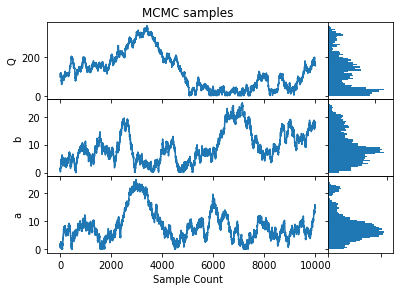

In [12]:
# Format samples and construct traceplots
params_samples_formatted = params_samples.copy()
for col in params_samples_formatted:
    params_samples_formatted[col] = params_samples_formatted[col].apply(lambda x: x.val)
traceplots(np.array(params_samples_formatted), xnames = params_samples_formatted.columns, title = 'MCMC samples')

RMSE = 705.6960059828747
Range = 10483.296070256554
Distance from peak value: 10688.8280888102


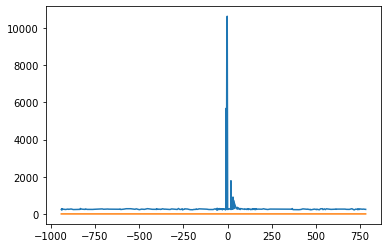

In [13]:
# Analyse the predictions
test_predictions = model_func(params,testing_data[:,1:])
GPM_analyser = GPM_analysis(test_predictions, testing_data)
RMSE = GPM_analyser.RMSE_func()
pdist = GPM_analyser.peak_distance()
GPM_analyser.compare_transects()

In [5]:
# Plotting slices of the plume at set Z values using the mean values of the parameters.

# x = np.linspace(0.1, 20, 201)
# y = np.linspace(-100, 100, 201)
# X,Y = np.meshgrid(x, y)
# Z = 5

# grid = np.zeros((x.size,3))
# grid[:,0] = x
# grid[:,1] = y
# grid[:,2] = np.ones(x.size)*Z

# C = model_func(params_mean, grid)
# plt.pcolor(x, y, C, shading = 'auto')
# plt.colorbar()
# plt.title('Plume concentration at z = ' + str(Z))
# plt.xlabel('x')
# plt.ylabel('y')
# print('Inferred means: a = ', round(params_mean[0], 2), ', b = ', round(params_mean[1], 2), ', Q = ', params_mean[2],'.', sep = '')

# del(x)
# del(y)